In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import torchvision.transforms.v2 as v2
import torchvision.transforms.functional as F
from torchvision.tv_tensors import Image, Mask
from tqdm import tqdm

In [ ]:
from google.colab import drive

# 드라이브 마운트
# drive.mount('/content/drive')

# device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


1. 미션 소개
    - 이번 미션에서는  모델을 활용하여 FashionMNIST 데이터셋의 각 패션 아이템(예: 티셔츠, 바지, 스니커즈 등)을 조건부로 생성하는 작업을 수행합니다. 각 클래스에 해당하는 이미지를 생성하는 cGAN (Conditional GAN) 모델을 직접 설계하고 학습시켜 보세요.

2. 데이터 소개
    - 데이터 링크: torchvision.datasets.FashionMNIST를 통해 바로 다운로드 가능합니다.
    - 데이터 구성:
        - 훈련 데이터: 60,000장의 이미지
        - 테스트 데이터: 10,000장의 이미지
        - 28×28 크기의 흑백 이미지 (10개 클래스)
    - 클래스 목록:
        - T-shirt/top
        - Trouser
        - Pullover
        - Dress
        - Coat
        - Sandal
        - Shirt
        - Sneaker
        - Bag
        - Ankle boot
3. 제출 안내
    - 다음 내용을 포함한 Colab Notebook 파일을 제출해 주세요.

    1. 분석 과정과 결과
        - 데이터 로드, 전처리, cGAN 모델 설계, 학습, 생성 이미지 예측 및 평가 과정을 순차적으로 진행해 주세요.
        - 조건부 레이블을 활용해 각 패션 아이템 클래스별로 이미지를 생성하는 모델을 구현하세요.
    2. 마크다운을 활용한 설명
        - 각 코드 셀이 수행하는 작업(의도, 알고리즘, 함수 설명 등)을 마크다운을 통해 자세히 기록해 주세요.
        - 노트북 내에서 코드와 결과를 한눈에 이해할 수 있도록 정리해 주세요.
    3. 모델 성능 평가 및 제출
        - 생성된 이미지의 품질을 정성적(시각적 평가) 및 정량적(FID, IS 등, optional)으로 평가해 보세요.
        - 테스트 데이터셋에 대한 모델의 조건부 생성 성능을 확인할 수 있는 결과와 함께 Notebook 파일을 제출해 주세요.
4. 참고 사항
    - 미션을 시작할 때 도움이 필요하다면, Baseline 코드를 참고할 수 있습니다. 이 코드는 기본적인 코드로 제공되며, 여러분이 원하는 대로 자유롭게 변형할 수 있어요.
        - 주의 사항: Baseline 코드는 여러분이 모델을 시작하는 데 도움을 주기 위한 참고 자료일 뿐이며, Baseline 코드를 그대로 사용하는 것보다는 이를 기반으로 자신의 아이디어를 추가하고 발전시키는 것이 중요합니다. 가능하면 스스로 모델을 구축해보고 다양한 방법을 시도하여 성능을 향상시켜 보세요.
    - 모델 성능 개선해 보기
        - 데이터 증강(Data Augmentation): 이미지 회전, 크롭, 밝기/대비 조절 등으로 모델의 일반화 성능을 높여보세요.
        - 하이퍼파라미터 튜닝: 학습률, 배치 크기, 에폭 수 등을 조정하여 최적의 성능을 도출해 보세요.
        - 모델 구조 개선: 조건부 생성 네트워크에 추가적인 레이어 등을 도입하여 성능 개선을 시도해 보세요.

# 0.연구 방법 및 결론

1. 데이터: FashionMNIST

2. 학습 : 검증 : 시험 = 5만 : 1만 : 1만

3. 증강 : 수평 뒤집기, 10도 회전

| 모델명 | Learning Rate | Beta1 | Batch Size | z_dim | Dropout Rate | Activation | D Loss (Epoch 10) | G Loss (Epoch 10) | D(x) (Epoch 10) | D(G(z)) (Epoch 10) |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| hyperparams_1 | 0.001 | 0.7 | 64 | 100 | 0.1 | ReLU | 0.6084 | 2.6678 | 0.80 | 0.20 |
| hyperparams_2 | 0.001 | 0.5 | 64 | 50 | 0.3 | LeakyReLU | 1.0586 | 1.4835 | 0.65 | 0.35 |
| hyperparams_3 | 0.01 | 0.9 | 128 | 200 | 0.5 | ReLU | 0.2226 | 6.6097 | 0.95 | 0.06 |
| hyperparams_4 | 0.01 | 0.5 | 128 | 50 | 0.3 | ReLU | 10.7915 | 1.7858 | 0.75 | 0.35 |
| hyperparams_5 | 0.01 | 0.7 | 128 | 50 | 0.5 | ReLU | 10.9795 | 7.8070 | 0.61 | 0.36 |
| hyperparams_6 | 0.001 | 0.5 | 128 | 200 | 0.1 | ReLU | 0.7146 | 2.1453 | 0.76 | 0.24 |
| hyperparams_7 | 0.001 | 0.9 | 64 | 100 | 0.3 | ReLU | 0.7217 | 2.2988 | 0.77 | 0.23 |
| hyperparams_8 | 0.01 | 0.5 | 128 | 200 | 0.1 | LeakyReLU | 0.9725 | 2.3119 | 0.70 | 0.30 |
| hyperparams_9 | 0.0001 | 0.9 | 128 | 50 | 0.5 | ReLU | 1.0723 | 1.2386 | 0.63 | 0.37 |
| hyperparams_10 | 0.001 | 0.9 | 32 | 200 | 0.3 | LeakyReLU | 0.7621 | 2.5027 | 0.77 | 0.23 |

4. 랜덤 하이퍼파라미터
    1. Learning Rate (증가 시 G Loss 증가)
        - Learning Rate가 낮은 경우(9): G Loss가 낮고 D Loss가 높음
        - Learning Rate가 높은 경우(3, 4, 5, 8): G Loss가 매우 증가
        - 특히 0.01에서 G Loss가 급증하는 경우가 많음.

    2. Beta1 (증가 시 G Loss 증가)
        - Beta1이 높은 경우(3, 9, 10): G Loss가 높음
        - Beta1이 낮은 경우(1, 2, 6): G Loss가 상대적으로 낮음

    3. Batch Size (증가 시 G Loss 감소)
        - Batch Size가 작은 경우(10): G Loss가 높은 편
        - Batch Size가 큰 경우(3, 4, 5, 6, 8, 9): G Loss가 낮은 경향

    4. z_dim (증가 시 G Loss 증가)
        - z_dim이 큰 경우(3, 6, 8, 10): G Loss가 높은 편
        - z_dim이 작은 경우(2, 4, 5, 9): G Loss가 낮은 편
        - z_dim이 클수록 생성 데이터가 더 복잡해질 가능성이 있음.

    5. Dropout Rate (증가 시 G Loss 감소)
        - Dropout이 낮은 경우(3, 6, 10): G Loss가 높음
        - Dropout이 높은 경우(1, 4, 5, 9): G Loss가 낮음

    6. Activation Function 영향
        - LeakyReLU 사용 시 (2, 8, 10): G Loss가 중간 정도 수준
        - ReLU 사용 시 (1, 4, 5, 7, 9): G Loss가 상대적으로 낮음
        - LeakyReLU가 판별자(Discriminator)에서 유리할 가능성이 높음.

5. 이후 실험 하이퍼파라미터
    - LR=1e-4, beta1=0.5(otimizer=Adam)
    - Batch size=128
    - z_dim=100
    - Dropout Rate=0.3
    - Activation=Generator(ReLU), Discriminator(LeakyReLU)
    - criterion=Binary Cross Entropy
    - num_epochs=50

6. Conditional GAN
    - Generator
        1. (batch, z_dim) → (batch, 128 × 7 × 7)
            - Linear(z_dim + num_classes → 128 × 7 × 7), ReLU
        2. (batch, 128, 7, 7) → (batch, 128, 7, 7)
            - Conv3x3(128 → 128), BN(128), ReLU
        3. (batch, 128, 7, 7) → (batch, 128, 14, 14)
            - Upsample(×2), Conv3x3(128 → 64), BN(64), ReLU
        4. (batch, 64, 14, 14) → (batch, 64, 14, 14)
            - Conv3x3(64 → 64), BN(64), ReLU
        5. (batch, 64, 14, 14) → (batch, 64, 28, 28)
            - Upsample(×2), Conv3x3(64 → 1), Tanh
    - Discriminator
        1. (batch, 1, 28, 28) → (batch, 64, 14, 14)
            - Conv3x3(1+1 → 64, stride=2), BN(64), LeakyReLU(0.2), Dropout(0.3)
        2. (batch, 64, 14, 14) → (batch, 64, 14, 14)
            - Conv3x3(64 → 64), BN(64), LeakyReLU(0.2), Dropout(0.3)
        3. (batch, 64, 14, 14) → (batch, 128, 7, 7)
            - Conv3x3(64 → 128, stride=2), BN(128), LeakyReLU(0.2), Dropout(0.3)
        4. (batch, 128, 7, 7) → (batch, 128, 7, 7)
            - Conv3x3(128 → 128), BN(128), LeakyReLU(0.2), Dropout(0.3)
        5. (batch, 128, 7, 7) → (batch, 1)
            - Flatten, Linear(128 × 7 × 7 → 1), Sigmoid
7. 결론
    - 일반적으로 추천되는 하이퍼파라미터를 사용하기 전에 실제로 유용한지 확인하기 위해서 랜덤하게 파라미터를 탐색했다. Learning Rate와 Dropout Rate의 경우 학습에 큰 영향을 끼쳤고 다른 하이퍼파라미터도 크고 작은 영향을 미쳤다.
    - FashionMNIST의 경우 크기가 28×28이라 3번 이상 Upsampling, Downsampling을 하게 되면 2로 나누어 떨어지지 않아서 3층을 쌓았고, Convolution을 한 번 더 진행하였다.
    - 그러나 검증과 시험 데이터에 적용한 결과는 좋지 않았다. Epoch을 늘린다기 보다는 모델을 조금 더 깊게 만들어야 하지 않을까하는 예상이 있다.
    - cGAN의 학습이 어렵다는 것을 느꼈다.

# 1.데이터 불러오기

In [ ]:
# 학습용 트랜스폼
train_transform = transforms.Compose(
    [
        # 수평 뒤집기, 10도 회전
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, )),
    ]
)
# 검증 및 시험용 트랜스폼
valtest_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, )),
    ]
)

In [ ]:
# 데이터셋 불러오기
dataset = torchvision.datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=None
)

# 학습 및 검증 데이터셋 나누기 (클래스별 비율 유지)
targets = np.array(dataset.targets)
train_idx, val_idx = train_test_split(
    np.arange(len(targets)), test_size=1/6, stratify=targets, random_state=1
)

# 트랜스폼 적용을 위한 커스텀 데이터셋
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image, label = self.dataset[self.indices[idx]]
        if self.transform:
            image = self.transform(image)
        return image, label

train_dataset = CustomDataset(dataset, train_idx, transform=train_transform)
val_dataset = CustomDataset(dataset, val_idx, transform=valtest_transform)

# 시험 데이터셋 불러오기
test_dataset = torchvision.datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=valtest_transform
)

In [ ]:
# 클래스 이름 (FashionMNIST 클래스)
idx_to_class = {i: class_name for i, class_name in enumerate(dataset.classes)}
idx_to_class

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

# 2.최적 하이퍼파라미터 탐색

In [ ]:
# 랜덤 그리드 서치를 위한 랜덤 파라미터
def sample_hyperparams():
    return {
        "lr": random.choice([1e-4, 1e-3, 1e-2]),
        "beta1": random.choice([0.5, 0.7, 0.9]),
        "batch_size": random.choice([32, 64, 128]),
        "z_dim": random.choice([50, 100, 200]),
        "dropout_rate": random.choice([0.1, 0.3, 0.5]),
        "activation": random.choice(["LeakyReLU", "ReLU"])
    }

# 1부터 10까지의 랜덤 하이퍼파라미터 생성
hyperparams_dict = {}
seen_params = set()

i = 1
while len(hyperparams_dict) < 10:
    new_params = sample_hyperparams()

    # 딕셔너리 튜플로 변환 후 중복 체크
    params_tuple = tuple(new_params.items())

    if params_tuple not in seen_params:
        var_name = f"hyperparams_{i}"
        hyperparams_dict[var_name] = new_params
        seen_params.add(params_tuple)
        i += 1

for key, value in hyperparams_dict.items():
    print(f"{key}: {value}")

hyperparams_1: {'lr': 0.001, 'beta1': 0.7, 'batch_size': 64, 'z_dim': 100, 'dropout_rate': 0.1, 'activation': 'ReLU'}
hyperparams_2: {'lr': 0.001, 'beta1': 0.5, 'batch_size': 64, 'z_dim': 50, 'dropout_rate': 0.3, 'activation': 'LeakyReLU'}
hyperparams_3: {'lr': 0.01, 'beta1': 0.9, 'batch_size': 128, 'z_dim': 200, 'dropout_rate': 0.5, 'activation': 'ReLU'}
hyperparams_4: {'lr': 0.01, 'beta1': 0.5, 'batch_size': 128, 'z_dim': 50, 'dropout_rate': 0.3, 'activation': 'ReLU'}
hyperparams_5: {'lr': 0.01, 'beta1': 0.7, 'batch_size': 128, 'z_dim': 50, 'dropout_rate': 0.5, 'activation': 'ReLU'}
hyperparams_6: {'lr': 0.001, 'beta1': 0.5, 'batch_size': 128, 'z_dim': 200, 'dropout_rate': 0.1, 'activation': 'ReLU'}
hyperparams_7: {'lr': 0.001, 'beta1': 0.9, 'batch_size': 64, 'z_dim': 100, 'dropout_rate': 0.3, 'activation': 'ReLU'}
hyperparams_8: {'lr': 0.01, 'beta1': 0.5, 'batch_size': 128, 'z_dim': 200, 'dropout_rate': 0.1, 'activation': 'LeakyReLU'}
hyperparams_9: {'lr': 0.0001, 'beta1': 0.9, 'bat

In [ ]:
# 데이터 로더 생성
dataloaders_dict = {}

for i, (key, params) in enumerate(hyperparams_dict.items(), start=1):
    batch_size = params["batch_size"]
    dataloaders_dict[f"train_loader_{i}"] = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    dataloaders_dict[f"val_loader_{i}"] = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False
    )

dataloaders_dict["test_loader"] = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

torch.Size([64, 1, 28, 28]) torch.Size([64])


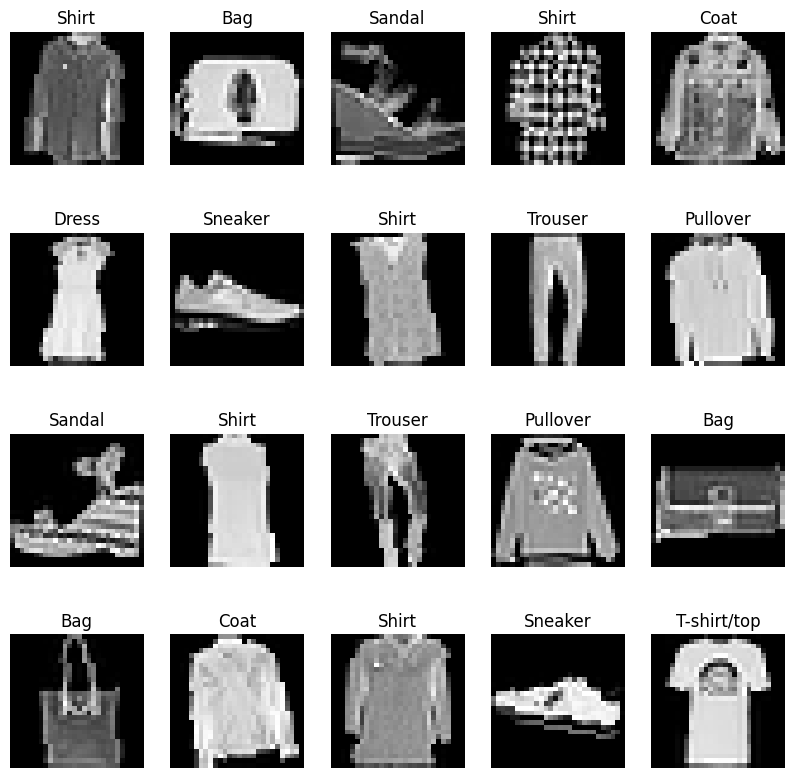

In [ ]:
# 증강 확인
images, labels = next(iter(dataloaders_dict["train_loader_1"]))

# 배치 사이즈 확인
print(images.size(), labels.size())

# 20개 시각화
plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    # 정규화 해제
    images[i] = images[i] * 0.5 + 0.5

    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(idx_to_class[labels[i].item()])
    plt.axis("off")
plt.show()

In [ ]:
image_size = 28
num_classes = 10
latent_dim = 100

# 생성자
class Generator(nn.Module):
    def __init__(self, z_dim, dropout_rate, activation, num_classes=10):
        super(Generator, self).__init__()

        # 라벨 임베딩
        self.label_embedding = nn.Embedding(num_classes, 10)

        # 시작 사이즈
        self.init_size = image_size // 4  # 7

        # L1 레이어
        self.l1 = nn.Sequential(
            nn.Linear(z_dim + num_classes, 128 * self.init_size ** 2),
            nn.ReLU(inplace=True),
        )

        # CNN 블록 구성
        layers = [
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),  # 7 → 14
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
        ]

        # 활성화 함수 선택
        activation_layers = {
            "LeakyReLU": nn.LeakyReLU(0.2, inplace=True),
            "ReLU": nn.ReLU(inplace=True),
        }

        if activation not in activation_layers:
            raise ValueError("Invalid activation function")

        layers.append(activation_layers[activation])

        layers.extend([
            nn.Upsample(scale_factor=2),  # 14 → 28
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # 출력 범위 [-1, 1]
        ])

        # CNN 블록 적용
        self.conv_blocks = nn.Sequential(*layers)

    def forward(self, noise, labels):
        label_input = self.label_embedding(labels)
        gen_input = torch.cat((noise, label_input), dim=-1)
        out = self.l1(gen_input)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


# 판별자
class Discriminator(nn.Module):
    def __init__(self, dropout_rate, activation, num_classes=10):
        super(Discriminator, self).__init__()

        # 라벨 임베딩
        self.label_embedding = nn.Embedding(num_classes, 1)

        # CNN 블록 구성
        layers = [
            nn.Conv2d(1 + 1, 64, kernel_size=3, stride=2, padding=1),  # 28 → 14
            nn.BatchNorm2d(64)
        ]

        # 활성화 함수 선택
        activation_layers = {
            "LeakyReLU": nn.LeakyReLU(0.2, inplace=True),
            "ReLU": nn.ReLU(inplace=True),
        }

        if activation not in activation_layers:
            raise ValueError("Invalid activation function")

        layers.extend([
            activation_layers[activation],
            nn.Dropout(dropout_rate),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # 14 → 7
            nn.BatchNorm2d(128),
            activation_layers[activation],
            nn.Dropout(dropout_rate),
            nn.Flatten(),
            nn.Linear(128 * (image_size // 4) ** 2, 1),  # 128 * 7 * 7
            nn.Sigmoid()
        ])

        # CNN 블록 적용
        self.conv_blocks = nn.Sequential(*layers)

    def forward(self, inputs, labels):
        batch_size = inputs.size(0)
        label = self.label_embedding(labels)
        label = label.view(batch_size, 1, 1, 1)
        label = label.expand(batch_size, 1, image_size, image_size)

        # 이미지와 라벨을 채널 차원에서 연결
        d_in = torch.cat((inputs, label), dim=1)
        validity = self.conv_blocks(d_in)
        return validity

In [ ]:
# 모델 확인
images, labels = next(iter(dataloaders_dict["train_loader_1"]))

generator = Generator(latent_dim, 0.3, "LeakyReLU")
discriminator = Discriminator(0.3, "LeakyReLU")

batch_size = images.shape[0]
z_dim = latent_dim
noise = torch.randn(batch_size, z_dim)

fake_images = generator(noise, labels)
print(f"생성된 가짜 이미지: {fake_images.shape}")

real_validity = discriminator(images, labels)
fake_validity = discriminator(fake_images, labels)
print(f"진짜 이미지: {real_validity.shape}, 가짜 이미지: {fake_validity.shape}")

생성된 가짜 이미지: torch.Size([64, 1, 28, 28])
진짜 이미지: torch.Size([64, 1]), 가짜 이미지: torch.Size([64, 1])


In [ ]:
def train_cGAN(hyperparams, dataloaders, device, idx_to_class, generator, discriminator, num_classes=10, num_epochs=30):
    lr = hyperparams["lr"]
    beta1 = hyperparams["beta1"]
    batch_size = hyperparams["batch_size"]
    z_dim = hyperparams["z_dim"]
    dropout_rate = hyperparams["dropout_rate"]
    activation = hyperparams["activation"]

    print(f"학습중인 파라미터: {hyperparams}")

    # 모델 초기화
    if generator is None:
        generator = Generator(z_dim, dropout_rate, activation).to(device)
    if discriminator is None:
        discriminator = Discriminator(dropout_rate, activation).to(device)

    # 손실함수, 옵티마이저
    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

    # 하이퍼파라미터에 맞는 데이터로더
    train_loader = dataloaders["train_loader"]

    # 학습루프
    for epoch in range(num_epochs):
        running_d_loss = 0.0
        running_g_loss = 0.0
        d_x_total = 0.0
        d_gz_total = 0.0
        total_samples = 0

        # 학습 진행 바
        train_progress = tqdm(train_loader, total=len(train_loader), leave=False)
        for i, (images, labels) in enumerate(train_progress):
            batch_size_current = images.size(0)
            total_samples += batch_size_current
            images, labels = images.to(device), labels.to(device)

            valid = torch.ones(batch_size_current, 1, device=device)
            fake = torch.zeros(batch_size_current, 1, device=device)

            # 판별자 학습
            optimizer_D.zero_grad()

            # 진짜 이미지 판별
            real_pred = discriminator(images, labels)
            real_loss = criterion(real_pred, valid)
            d_x_total += real_pred.mean().item() * batch_size_current

            # 가짜 이미지 생성
            noise = torch.randn(batch_size_current, z_dim, device=device)
            gen_labels = labels
            gen_images = generator(noise, gen_labels)

            # 가짜 이미지 판별
            fake_pred = discriminator(gen_images.detach(), labels)
            fake_loss = criterion(fake_pred, fake)
            d_gz_total += fake_pred.mean().item() * batch_size_current

            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_D.step()

            # 생성자 학습
            optimizer_G.zero_grad()
            g_loss = criterion(discriminator(gen_images, gen_labels), valid)
            g_loss.backward()
            optimizer_G.step()

            # 러닝 로스
            running_d_loss += d_loss.item() * batch_size_current
            running_g_loss += g_loss.item() * batch_size_current

            # 진행바 업데이트
            train_progress.set_description(f"Epoch [{epoch+1}/{num_epochs}] - D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

        # 평균 손실, 확률 계산
        avg_d_loss = running_d_loss / total_samples
        avg_g_loss = running_g_loss / total_samples
        avg_d_x = d_x_total / total_samples
        avg_d_gz = d_gz_total / total_samples

        print(f"Epoch [{epoch+1}/{num_epochs}] - D Loss: {avg_d_loss:.4f}, G Loss: {avg_g_loss:.4f}, D(x): {avg_d_x:.2f}, D(G(z)): {avg_d_gz:.2f}")

        # 10 에포크마다 생성 이미지 시각화
        if (epoch + 1) % 10 == 0:
            generator.eval()
            n_row = 3   # 클래스별 3개
            n_col = 10  # 총 10개 클래스
            total_samples = n_row * n_col
            noise = torch.randn(total_samples, z_dim, device=device)
            labels_sample = torch.arange(0, 10, device=device).repeat(n_row)
            gen_imgs = generator(noise, labels_sample).detach().cpu()

            # 정규화 해제
            gen_imgs = gen_imgs.clone() * 0.5 + 0.5
            gen_imgs = gen_imgs.clamp(0, 1)

            # 서브플롯 생성
            fig, axes = plt.subplots(n_row, n_col, figsize=(n_col, n_row))
            for i in range(n_row):
                for j in range(n_col):
                    idx = i * n_col + j
                    axes[i, j].imshow(gen_imgs[idx, 0, :, :], cmap='gray')
                    axes[i, j].axis('off')
                    if i == 0:
                        axes[i, j].set_title(idx_to_class[j], fontsize=10)
            plt.tight_layout()
            plt.show()
            generator.train()

In [ ]:
def train_multiple_cGAN(hyperparams_dict, dataloaders_dict, device, idx_to_class, num_classes=10, num_epochs=30):
    # 모델 저장용 딕셔너리
    models = {}

    for i, (key, hyperparams) in enumerate(hyperparams_dict.items(), start=1):
        print(f"학습 중인 모델: {key}")

        # 데이터로더 설정
        dataloaders = {
            "train_loader": dataloaders_dict[f"train_loader_{i}"],
        }

        # 모델 설정
        generator = Generator(hyperparams["z_dim"], hyperparams["dropout_rate"], hyperparams["activation"]).to(device)
        discriminator = Discriminator(hyperparams["dropout_rate"], hyperparams["activation"]).to(device)

        # 모델 저장
        models[key] = {
            "generator": generator,
            "discriminator": discriminator
        }

        # 학습
        train_cGAN(hyperparams, dataloaders, device, idx_to_class, generator, discriminator, num_classes=10, num_epochs=10)

학습 중인 모델: hyperparams_1
학습중인 파라미터: {'lr': 0.001, 'beta1': 0.7, 'batch_size': 64, 'z_dim': 100, 'dropout_rate': 0.1, 'activation': 'ReLU'}


Epoch [1/10] - D Loss: 0.9227, G Loss: 1.6800, D(x): 0.68, D(G(z)): 0.32


Epoch [2/10] - D Loss: 0.9615, G Loss: 1.6095, D(x): 0.68, D(G(z)): 0.32


Epoch [3/10] - D Loss: 0.9440, G Loss: 1.5937, D(x): 0.68, D(G(z)): 0.32


Epoch [4/10] - D Loss: 0.8388, G Loss: 1.8105, D(x): 0.72, D(G(z)): 0.28


Epoch [5/10] - D Loss: 0.7257, G Loss: 2.0915, D(x): 0.75, D(G(z)): 0.24


Epoch [6/10] - D Loss: 0.6766, G Loss: 2.2717, D(x): 0.77, D(G(z)): 0.23


Epoch [7/10] - D Loss: 0.6533, G Loss: 2.4323, D(x): 0.78, D(G(z)): 0.21


Epoch [8/10] - D Loss: 0.6363, G Loss: 2.4824, D(x): 0.79, D(G(z)): 0.21


Epoch [9/10] - D Loss: 0.6082, G Loss: 2.5878, D(x): 0.80, D(G(z)): 0.20


Epoch [10/10] - D Loss: 0.6084, G Loss: 2.6678, D(x): 0.80, D(G(z)): 0.20


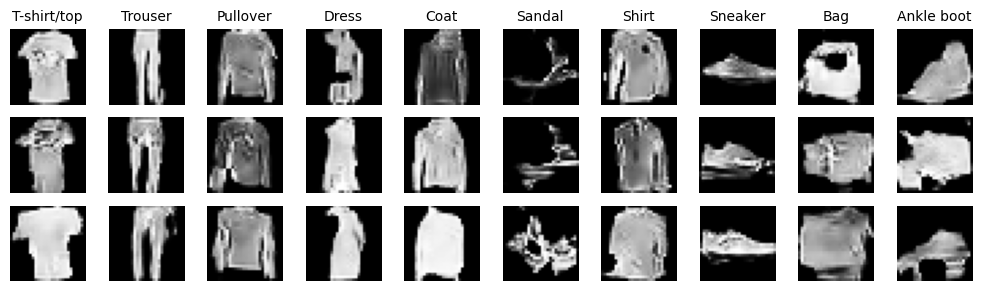

학습 중인 모델: hyperparams_2
학습중인 파라미터: {'lr': 0.001, 'beta1': 0.5, 'batch_size': 64, 'z_dim': 50, 'dropout_rate': 0.3, 'activation': 'LeakyReLU'}


Epoch [1/10] - D Loss: 1.2048, G Loss: 1.3060, D(x): 0.60, D(G(z)): 0.40


Epoch [2/10] - D Loss: 1.1179, G Loss: 1.4076, D(x): 0.63, D(G(z)): 0.37


Epoch [3/10] - D Loss: 1.0906, G Loss: 1.4241, D(x): 0.64, D(G(z)): 0.36


Epoch [4/10] - D Loss: 1.0873, G Loss: 1.4485, D(x): 0.64, D(G(z)): 0.36


Epoch [5/10] - D Loss: 1.0735, G Loss: 1.4459, D(x): 0.64, D(G(z)): 0.35


Epoch [6/10] - D Loss: 1.0737, G Loss: 1.4533, D(x): 0.65, D(G(z)): 0.35


Epoch [7/10] - D Loss: 1.0637, G Loss: 1.4931, D(x): 0.65, D(G(z)): 0.35


Epoch [8/10] - D Loss: 1.0676, G Loss: 1.4588, D(x): 0.65, D(G(z)): 0.35


Epoch [9/10] - D Loss: 1.0582, G Loss: 1.4844, D(x): 0.65, D(G(z)): 0.35


Epoch [10/10] - D Loss: 1.0586, G Loss: 1.4835, D(x): 0.65, D(G(z)): 0.35


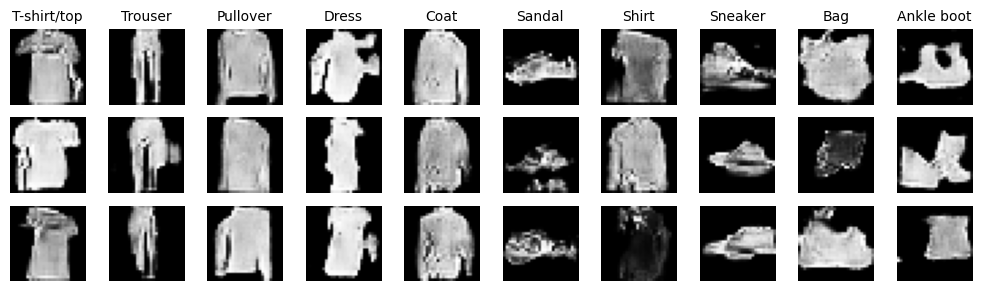

학습 중인 모델: hyperparams_3
학습중인 파라미터: {'lr': 0.01, 'beta1': 0.9, 'batch_size': 128, 'z_dim': 200, 'dropout_rate': 0.5, 'activation': 'ReLU'}


Epoch [1/10] - D Loss: 1.0320, G Loss: 4.8574, D(x): 0.82, D(G(z)): 0.19


Epoch [2/10] - D Loss: 0.5480, G Loss: 4.4143, D(x): 0.84, D(G(z)): 0.16


Epoch [3/10] - D Loss: 0.5901, G Loss: 3.5109, D(x): 0.83, D(G(z)): 0.18


Epoch [4/10] - D Loss: 0.4065, G Loss: 5.1061, D(x): 0.88, D(G(z)): 0.12


Epoch [5/10] - D Loss: 0.4147, G Loss: 4.3045, D(x): 0.88, D(G(z)): 0.13


Epoch [6/10] - D Loss: 0.2251, G Loss: 5.4463, D(x): 0.93, D(G(z)): 0.07


Epoch [7/10] - D Loss: 0.4268, G Loss: 5.1142, D(x): 0.89, D(G(z)): 0.11


Epoch [8/10] - D Loss: 0.1940, G Loss: 5.8867, D(x): 0.94, D(G(z)): 0.06


Epoch [9/10] - D Loss: 0.3791, G Loss: 5.6609, D(x): 0.90, D(G(z)): 0.10


Epoch [10/10] - D Loss: 0.2226, G Loss: 6.6097, D(x): 0.95, D(G(z)): 0.06


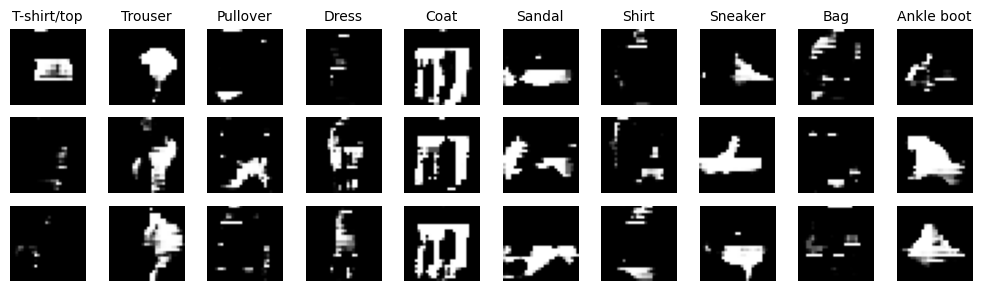

학습 중인 모델: hyperparams_4
학습중인 파라미터: {'lr': 0.01, 'beta1': 0.5, 'batch_size': 128, 'z_dim': 50, 'dropout_rate': 0.3, 'activation': 'ReLU'}


Epoch [1/10] - D Loss: 11.1774, G Loss: 0.8474, D(x): 0.55, D(G(z)): 0.54


Epoch [2/10] - D Loss: 11.2251, G Loss: 0.7182, D(x): 0.57, D(G(z)): 0.54


Epoch [3/10] - D Loss: 11.2116, G Loss: 0.7600, D(x): 0.57, D(G(z)): 0.53


Epoch [4/10] - D Loss: 11.1575, G Loss: 0.8511, D(x): 0.59, D(G(z)): 0.51


Epoch [5/10] - D Loss: 11.1165, G Loss: 7.6803, D(x): 0.54, D(G(z)): 0.42


Epoch [6/10] - D Loss: 11.0114, G Loss: 11.1148, D(x): 0.55, D(G(z)): 0.35


Epoch [7/10] - D Loss: 9.6024, G Loss: 10.0266, D(x): 0.59, D(G(z)): 0.31


Epoch [8/10] - D Loss: 10.5277, G Loss: 2.4008, D(x): 0.68, D(G(z)): 0.40


Epoch [9/10] - D Loss: 10.8630, G Loss: 1.5794, D(x): 0.72, D(G(z)): 0.38


Epoch [10/10] - D Loss: 10.7915, G Loss: 1.7858, D(x): 0.75, D(G(z)): 0.35


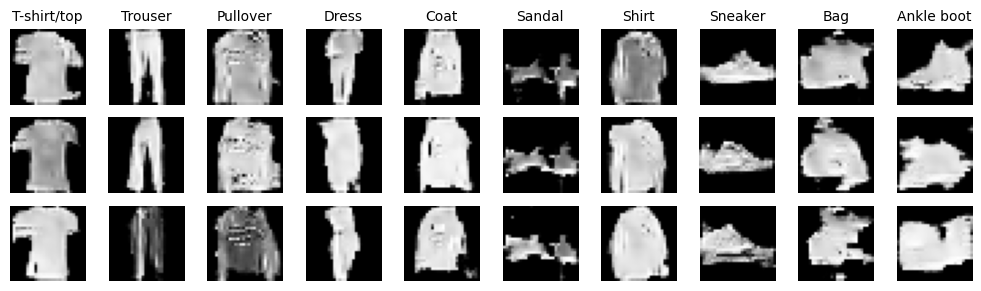

학습 중인 모델: hyperparams_5
학습중인 파라미터: {'lr': 0.01, 'beta1': 0.7, 'batch_size': 128, 'z_dim': 50, 'dropout_rate': 0.5, 'activation': 'ReLU'}


Epoch [1/10] - D Loss: 13.3963, G Loss: 6.5838, D(x): 0.59, D(G(z)): 0.42


Epoch [2/10] - D Loss: 11.1294, G Loss: 0.9095, D(x): 0.61, D(G(z)): 0.50


Epoch [3/10] - D Loss: 11.1116, G Loss: 0.9316, D(x): 0.62, D(G(z)): 0.49


Epoch [4/10] - D Loss: 11.0686, G Loss: 1.0450, D(x): 0.64, D(G(z)): 0.46


Epoch [5/10] - D Loss: 11.0137, G Loss: 1.1986, D(x): 0.66, D(G(z)): 0.44


Epoch [6/10] - D Loss: 11.0038, G Loss: 1.2105, D(x): 0.67, D(G(z)): 0.44


Epoch [7/10] - D Loss: 10.9744, G Loss: 1.2838, D(x): 0.68, D(G(z)): 0.42


Epoch [8/10] - D Loss: 10.9410, G Loss: 1.3564, D(x): 0.69, D(G(z)): 0.41


Epoch [9/10] - D Loss: 10.9937, G Loss: 1.2179, D(x): 0.67, D(G(z)): 0.43


Epoch [10/10] - D Loss: 10.9795, G Loss: 7.8070, D(x): 0.61, D(G(z)): 0.36


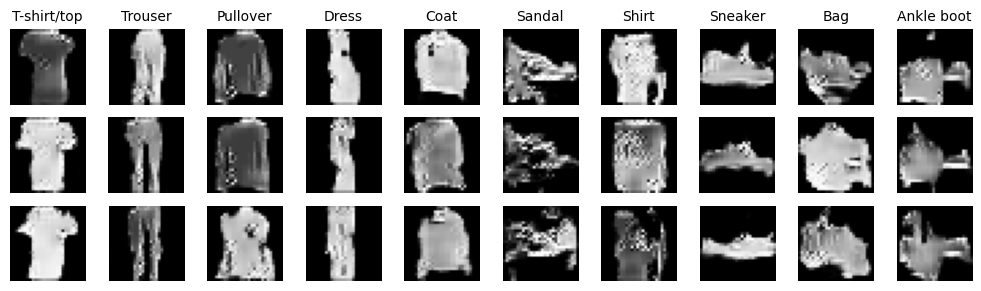

학습 중인 모델: hyperparams_6
학습중인 파라미터: {'lr': 0.001, 'beta1': 0.5, 'batch_size': 128, 'z_dim': 200, 'dropout_rate': 0.1, 'activation': 'ReLU'}


Epoch [1/10] - D Loss: 1.1016, G Loss: 1.3032, D(x): 0.62, D(G(z)): 0.38


Epoch [2/10] - D Loss: 1.0278, G Loss: 1.3577, D(x): 0.64, D(G(z)): 0.35


Epoch [3/10] - D Loss: 1.0511, G Loss: 1.3341, D(x): 0.64, D(G(z)): 0.36


Epoch [4/10] - D Loss: 1.0009, G Loss: 1.4111, D(x): 0.65, D(G(z)): 0.35


Epoch [5/10] - D Loss: 0.9237, G Loss: 1.5583, D(x): 0.68, D(G(z)): 0.32


Epoch [6/10] - D Loss: 0.8344, G Loss: 1.7177, D(x): 0.71, D(G(z)): 0.29


Epoch [7/10] - D Loss: 0.7937, G Loss: 1.8505, D(x): 0.73, D(G(z)): 0.27


Epoch [8/10] - D Loss: 0.7475, G Loss: 1.9801, D(x): 0.74, D(G(z)): 0.26


Epoch [9/10] - D Loss: 0.7200, G Loss: 2.0746, D(x): 0.75, D(G(z)): 0.24


Epoch [10/10] - D Loss: 0.7146, G Loss: 2.1453, D(x): 0.76, D(G(z)): 0.24


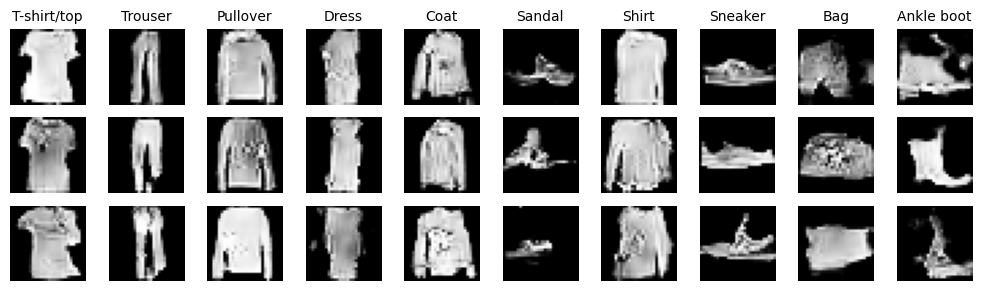

학습 중인 모델: hyperparams_7
학습중인 파라미터: {'lr': 0.001, 'beta1': 0.9, 'batch_size': 64, 'z_dim': 100, 'dropout_rate': 0.3, 'activation': 'ReLU'}


Epoch [1/10] - D Loss: 0.7136, G Loss: 3.3343, D(x): 0.80, D(G(z)): 0.20


Epoch [2/10] - D Loss: 0.6625, G Loss: 2.9933, D(x): 0.80, D(G(z)): 0.20


Epoch [3/10] - D Loss: 0.6019, G Loss: 2.9030, D(x): 0.81, D(G(z)): 0.19


Epoch [4/10] - D Loss: 0.6992, G Loss: 2.8245, D(x): 0.79, D(G(z)): 0.21


Epoch [5/10] - D Loss: 0.7474, G Loss: 2.5943, D(x): 0.78, D(G(z)): 0.22


Epoch [6/10] - D Loss: 0.7686, G Loss: 2.3828, D(x): 0.76, D(G(z)): 0.24


Epoch [7/10] - D Loss: 0.7725, G Loss: 2.2575, D(x): 0.76, D(G(z)): 0.24


Epoch [8/10] - D Loss: 0.7342, G Loss: 2.3886, D(x): 0.77, D(G(z)): 0.23


Epoch [9/10] - D Loss: 0.7298, G Loss: 2.3803, D(x): 0.77, D(G(z)): 0.23


Epoch [10/10] - D Loss: 0.7217, G Loss: 2.2988, D(x): 0.77, D(G(z)): 0.23


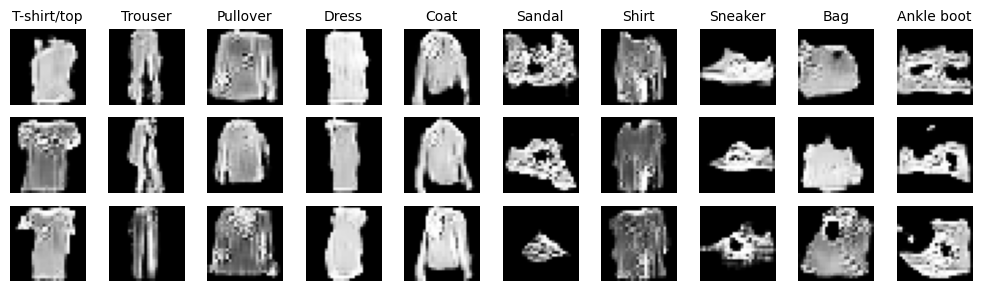

학습 중인 모델: hyperparams_8
학습중인 파라미터: {'lr': 0.01, 'beta1': 0.5, 'batch_size': 128, 'z_dim': 200, 'dropout_rate': 0.1, 'activation': 'LeakyReLU'}


Epoch [1/10] - D Loss: 1.6591, G Loss: 1.6292, D(x): 0.57, D(G(z)): 0.44


Epoch [2/10] - D Loss: 1.2639, G Loss: 1.4023, D(x): 0.59, D(G(z)): 0.41


Epoch [3/10] - D Loss: 1.1682, G Loss: 1.5910, D(x): 0.62, D(G(z)): 0.38


Epoch [4/10] - D Loss: 1.1397, G Loss: 1.6248, D(x): 0.63, D(G(z)): 0.37


Epoch [5/10] - D Loss: 1.1002, G Loss: 1.7676, D(x): 0.65, D(G(z)): 0.35


Epoch [6/10] - D Loss: 1.0643, G Loss: 1.8530, D(x): 0.66, D(G(z)): 0.34


Epoch [7/10] - D Loss: 1.0327, G Loss: 1.9772, D(x): 0.67, D(G(z)): 0.32


Epoch [8/10] - D Loss: 1.0166, G Loss: 2.0569, D(x): 0.68, D(G(z)): 0.32


Epoch [9/10] - D Loss: 1.0004, G Loss: 2.1719, D(x): 0.69, D(G(z)): 0.31


Epoch [10/10] - D Loss: 0.9725, G Loss: 2.3119, D(x): 0.70, D(G(z)): 0.30


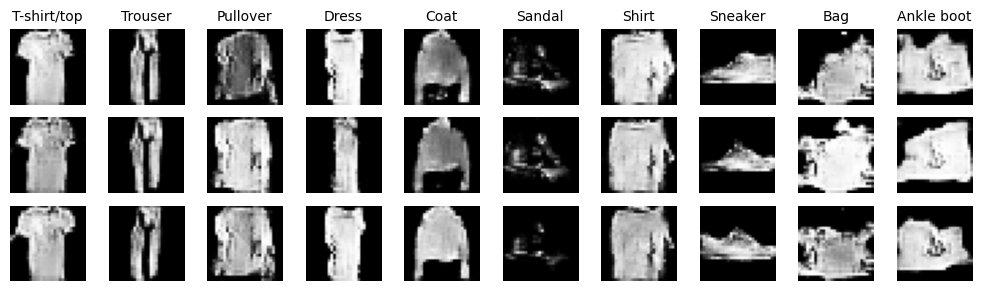

학습 중인 모델: hyperparams_9
학습중인 파라미터: {'lr': 0.0001, 'beta1': 0.9, 'batch_size': 128, 'z_dim': 50, 'dropout_rate': 0.5, 'activation': 'ReLU'}


Epoch [1/10] - D Loss: 1.1914, G Loss: 0.9701, D(x): 0.59, D(G(z)): 0.42


Epoch [2/10] - D Loss: 1.0753, G Loss: 1.2010, D(x): 0.63, D(G(z)): 0.37


Epoch [3/10] - D Loss: 0.9702, G Loss: 1.3480, D(x): 0.66, D(G(z)): 0.34


Epoch [4/10] - D Loss: 0.9921, G Loss: 1.3327, D(x): 0.66, D(G(z)): 0.34


Epoch [5/10] - D Loss: 1.0193, G Loss: 1.2623, D(x): 0.65, D(G(z)): 0.35


Epoch [6/10] - D Loss: 0.9974, G Loss: 1.2978, D(x): 0.65, D(G(z)): 0.35


Epoch [7/10] - D Loss: 1.0333, G Loss: 1.2570, D(x): 0.64, D(G(z)): 0.36


Epoch [8/10] - D Loss: 1.0436, G Loss: 1.2485, D(x): 0.64, D(G(z)): 0.36


Epoch [9/10] - D Loss: 1.0751, G Loss: 1.2252, D(x): 0.63, D(G(z)): 0.37


Epoch [10/10] - D Loss: 1.0723, G Loss: 1.2386, D(x): 0.63, D(G(z)): 0.37


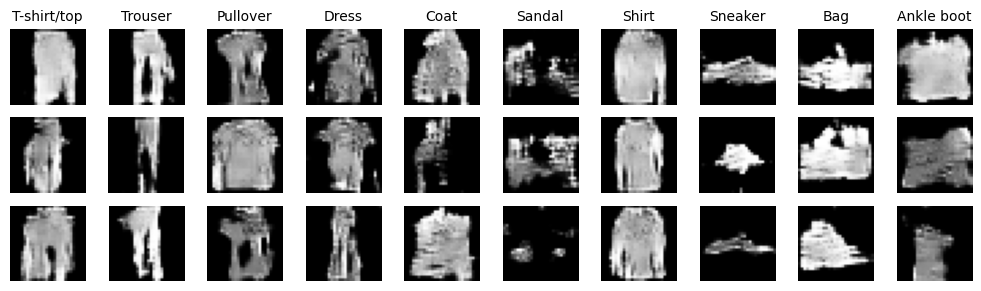

학습 중인 모델: hyperparams_10
학습중인 파라미터: {'lr': 0.001, 'beta1': 0.9, 'batch_size': 32, 'z_dim': 200, 'dropout_rate': 0.3, 'activation': 'LeakyReLU'}


Epoch [1/10] - D Loss: 1.0143, G Loss: 2.5057, D(x): 0.73, D(G(z)): 0.27


Epoch [2/10] - D Loss: 0.7607, G Loss: 2.6175, D(x): 0.77, D(G(z)): 0.23


Epoch [3/10] - D Loss: 0.6882, G Loss: 2.7193, D(x): 0.79, D(G(z)): 0.21


Epoch [4/10] - D Loss: 0.6668, G Loss: 2.7925, D(x): 0.80, D(G(z)): 0.20


Epoch [5/10] - D Loss: 0.6309, G Loss: 2.8981, D(x): 0.80, D(G(z)): 0.20


Epoch [6/10] - D Loss: 0.6789, G Loss: 2.9247, D(x): 0.80, D(G(z)): 0.20


Epoch [7/10] - D Loss: 0.7146, G Loss: 2.5344, D(x): 0.78, D(G(z)): 0.22


Epoch [8/10] - D Loss: 0.7438, G Loss: 2.5368, D(x): 0.77, D(G(z)): 0.22


Epoch [9/10] - D Loss: 0.7314, G Loss: 2.5535, D(x): 0.78, D(G(z)): 0.22


Epoch [10/10] - D Loss: 0.7621, G Loss: 2.5027, D(x): 0.77, D(G(z)): 0.23


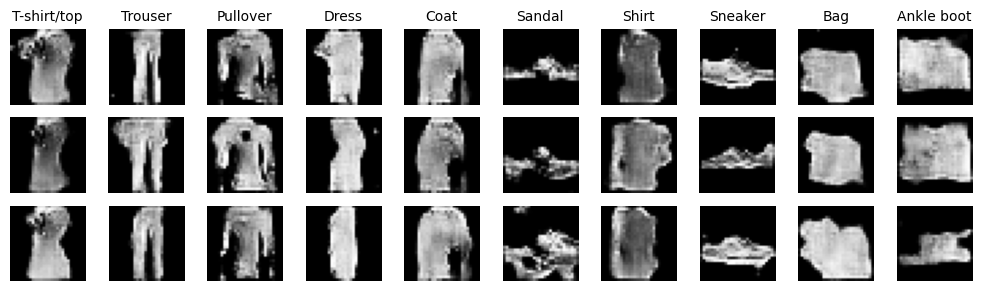

In [ ]:
# 여러 개의 cGAN 모델 학습
train_multiple_cGAN(hyperparams_dict, dataloaders_dict, device, idx_to_class, num_classes=10, num_epochs=10)

| 모델명 | Learning Rate | Beta1 | Batch Size | z_dim | Dropout Rate | Activation | D Loss (Epoch 10) | G Loss (Epoch 10) | D(x) (Epoch 10) | D(G(z)) (Epoch 10) |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| hyperparams_1 | 0.001 | 0.7 | 64 | 100 | 0.1 | ReLU | 0.6084 | 2.6678 | 0.80 | 0.20 |
| hyperparams_2 | 0.001 | 0.5 | 64 | 50 | 0.3 | LeakyReLU | 1.0586 | 1.4835 | 0.65 | 0.35 |
| hyperparams_3 | 0.01 | 0.9 | 128 | 200 | 0.5 | ReLU | 0.2226 | 6.6097 | 0.95 | 0.06 |
| hyperparams_4 | 0.01 | 0.5 | 128 | 50 | 0.3 | ReLU | 10.7915 | 1.7858 | 0.75 | 0.35 |
| hyperparams_5 | 0.01 | 0.7 | 128 | 50 | 0.5 | ReLU | 10.9795 | 7.8070 | 0.61 | 0.36 |
| hyperparams_6 | 0.001 | 0.5 | 128 | 200 | 0.1 | ReLU | 0.7146 | 2.1453 | 0.76 | 0.24 |
| hyperparams_7 | 0.001 | 0.9 | 64 | 100 | 0.3 | ReLU | 0.7217 | 2.2988 | 0.77 | 0.23 |
| hyperparams_8 | 0.01 | 0.5 | 128 | 200 | 0.1 | LeakyReLU | 0.9725 | 2.3119 | 0.70 | 0.30 |
| hyperparams_9 | 0.0001 | 0.9 | 128 | 50 | 0.5 | ReLU | 1.0723 | 1.2386 | 0.63 | 0.37 |
| hyperparams_10 | 0.001 | 0.9 | 32 | 200 | 0.3 | LeakyReLU | 0.7621 | 2.5027 | 0.77 | 0.23 |

1. Learning Rate (증가 시 G Loss 증가)
    - Learning Rate가 낮은 경우(9): G Loss가 낮고 D Loss가 높음
    - Learning Rate가 높은 경우(3, 4, 5, 8): G Loss가 매우 증가
    - 특히 0.01에서 G Loss가 급증하는 경우가 많음.

2. Beta1 (증가 시 G Loss 증가)
    - Beta1이 높은 경우(3, 9, 10): G Loss가 높음
    - Beta1이 낮은 경우(1, 2, 6): G Loss가 상대적으로 낮음

3. Batch Size (증가 시 G Loss 감소)
    - Batch Size가 작은 경우(10): G Loss가 높은 편
    - Batch Size가 큰 경우(3, 4, 5, 6, 8, 9): G Loss가 낮은 경향

4. z_dim (증가 시 G Loss 증가)
    - z_dim이 큰 경우(3, 6, 8, 10): G Loss가 높은 편
    - z_dim이 작은 경우(2, 4, 5, 9): G Loss가 낮은 편
    - z_dim이 클수록 생성 데이터가 더 복잡해질 가능성이 있음.

5. Dropout Rate (증가 시 G Loss 감소)
    - Dropout이 낮은 경우(3, 6, 10): G Loss가 높음
    - Dropout이 높은 경우(1, 4, 5, 9): G Loss가 낮음

6. Activation Function 영향
    - LeakyReLU 사용 시 (2, 8, 10): G Loss가 중간 정도 수준
    - ReLU 사용 시 (1, 4, 5, 7, 9): G Loss가 상대적으로 낮음
    - LeakyReLU가 판별자(Discriminator)에서 유리할 가능성이 높음.

향후 실험 하이퍼파라미터 : LR=1e-4, beta1=0.5, Batch size=128, z_dim=100, Dropout Rate=0.3, Activation=Generator(ReLU), Discriminator(LeakyReLU)

# 3.최종 모델 실행

In [ ]:
# 데이터로더 설정
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

images, labels = next(iter(train_loader))

# 배치 사이즈 확인
print(images.size(), labels.size())

# 클래스 이름 (FashionMNIST 클래스)
idx_to_class = {i: class_name for i, class_name in enumerate(dataset.classes)}
idx_to_class

torch.Size([128, 1, 28, 28]) torch.Size([128])


{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [ ]:
image_size = 28      # Fashion MNIST 이미지 크기
num_classes = 10     # 10개 클래스
z_dim = 100     # 잠재 공간 차원

# 생성자 (Generator)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # 레이블 임베딩
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.init_size = image_size // 4  # 7

        self.l1 = nn.Sequential(
            nn.Linear(z_dim + num_classes, 128 * self.init_size * self.init_size),
            nn.ReLU(inplace=True)
        )

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),    # 컨볼루션 추가
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2),  # 7 → 14
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),      # 컨볼루션 추가
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2),  # 14 → 28
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # 출력 범위 [-1, 1]
        )

    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        gen_input = torch.cat((noise, label_input), -1)
        out = self.l1(gen_input)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

# 판별자 (Discriminator)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # 레이블을 단일 채널 값으로 임베딩
        self.label_emb = nn.Embedding(num_classes, 1)

        self.model = nn.Sequential(
            # 이미지(1 채널)와 레이블(1 채널)을 채널 차원에서 결합하여 2채널로 입력
            nn.Conv2d(1 + 1, 64, kernel_size=3, stride=2, padding=1),  # 28 → 14
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),      # 컨볼루션 추가
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),      # 14 → 7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),    # 컨볼루션 추가
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Flatten(),
            nn.Linear(128 * (image_size // 4) * (image_size // 4), 1),   # 128*7*7
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        batch_size = img.size(0)
        label = self.label_emb(labels)
        label = label.view(batch_size, 1, 1, 1)
        label = label.expand(batch_size, 1, image_size, image_size)
        # 이미지와 레이블을 채널 차원에서 연결
        d_in = torch.cat((img, label), 1)
        validity = self.model(d_in)
        return validity

In [ ]:
# 모델 초기화
generator = Generator().to(device)
discriminator = Discriminator().to(device)

num_epochs = 50
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

Epoch [1/50] - D Loss: 1.1268, G Loss: 1.1302, D(x): 0.60, D(G(z)): 0.40


Epoch [2/50] - D Loss: 1.0045, G Loss: 1.3303, D(x): 0.65, D(G(z)): 0.35


Epoch [3/50] - D Loss: 0.9991, G Loss: 1.3399, D(x): 0.65, D(G(z)): 0.35


Epoch [4/50] - D Loss: 0.9236, G Loss: 1.4349, D(x): 0.67, D(G(z)): 0.32


Epoch [5/50] - D Loss: 1.0210, G Loss: 1.2808, D(x): 0.64, D(G(z)): 0.36


Epoch [6/50] - D Loss: 1.0934, G Loss: 1.1790, D(x): 0.62, D(G(z)): 0.38


Epoch [7/50] - D Loss: 1.1386, G Loss: 1.0989, D(x): 0.60, D(G(z)): 0.40


Epoch [8/50] - D Loss: 1.1328, G Loss: 1.0994, D(x): 0.60, D(G(z)): 0.39


Epoch [9/50] - D Loss: 1.1344, G Loss: 1.1061, D(x): 0.61, D(G(z)): 0.39


Epoch [10/50] - D Loss: 1.1087, G Loss: 1.1338, D(x): 0.61, D(G(z)): 0.39


Validation[10] - D Loss: 0.6280, G Loss: 1.5448, D(x): 0.55, D(G(z)): 0.35


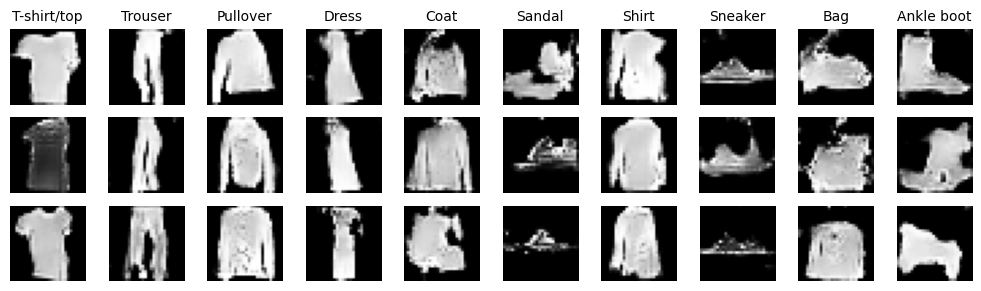

모델 저장 완료: generator_epoch_10.pth, discriminator_epoch_10.pth


Epoch [11/50] - D Loss: 1.0942, G Loss: 1.1599, D(x): 0.62, D(G(z)): 0.38


Epoch [12/50] - D Loss: 1.0955, G Loss: 1.1683, D(x): 0.62, D(G(z)): 0.38


Epoch [13/50] - D Loss: 1.0919, G Loss: 1.1721, D(x): 0.62, D(G(z)): 0.38


Epoch [14/50] - D Loss: 1.0833, G Loss: 1.1871, D(x): 0.62, D(G(z)): 0.38


Epoch [15/50] - D Loss: 1.0646, G Loss: 1.2130, D(x): 0.63, D(G(z)): 0.37


Epoch [16/50] - D Loss: 1.0448, G Loss: 1.2540, D(x): 0.64, D(G(z)): 0.36


Epoch [17/50] - D Loss: 1.0121, G Loss: 1.3096, D(x): 0.65, D(G(z)): 0.35


Epoch [18/50] - D Loss: 0.9799, G Loss: 1.3468, D(x): 0.66, D(G(z)): 0.34


Epoch [19/50] - D Loss: 0.9455, G Loss: 1.4097, D(x): 0.67, D(G(z)): 0.33


Epoch [20/50] - D Loss: 0.9190, G Loss: 1.4682, D(x): 0.68, D(G(z)): 0.32


Validation[20] - D Loss: 0.5772, G Loss: 1.6557, D(x): 0.59, D(G(z)): 0.33


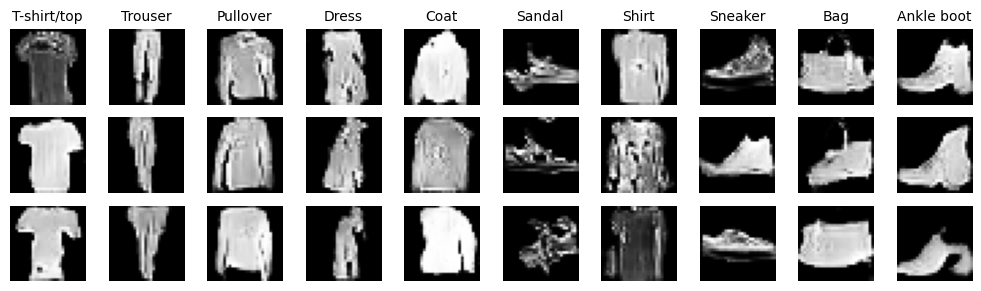

모델 저장 완료: generator_epoch_20.pth, discriminator_epoch_20.pth


Epoch [21/50] - D Loss: 0.9080, G Loss: 1.5121, D(x): 0.68, D(G(z)): 0.32


Epoch [22/50] - D Loss: 0.8838, G Loss: 1.5552, D(x): 0.69, D(G(z)): 0.31


Epoch [23/50] - D Loss: 0.8817, G Loss: 1.6068, D(x): 0.69, D(G(z)): 0.30


Epoch [24/50] - D Loss: 0.8541, G Loss: 1.6243, D(x): 0.70, D(G(z)): 0.30


Epoch [25/50] - D Loss: 0.8259, G Loss: 1.6777, D(x): 0.71, D(G(z)): 0.29


Epoch [26/50] - D Loss: 0.8152, G Loss: 1.7313, D(x): 0.72, D(G(z)): 0.28


Epoch [27/50] - D Loss: 0.8108, G Loss: 1.7584, D(x): 0.72, D(G(z)): 0.28


Epoch [28/50] - D Loss: 0.7948, G Loss: 1.8075, D(x): 0.72, D(G(z)): 0.27


Epoch [29/50] - D Loss: 0.7846, G Loss: 1.8530, D(x): 0.73, D(G(z)): 0.27


Epoch [30/50] - D Loss: 0.7564, G Loss: 1.8613, D(x): 0.74, D(G(z)): 0.26


Validation[30] - D Loss: 0.6356, G Loss: 1.9338, D(x): 0.56, D(G(z)): 0.23


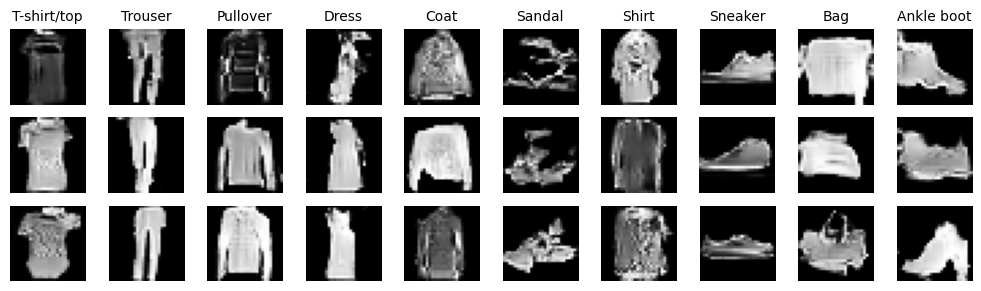

모델 저장 완료: generator_epoch_30.pth, discriminator_epoch_30.pth


Epoch [31/50] - D Loss: 0.7592, G Loss: 1.8748, D(x): 0.74, D(G(z)): 0.26


Epoch [32/50] - D Loss: 0.7387, G Loss: 1.9698, D(x): 0.74, D(G(z)): 0.25


Epoch [33/50] - D Loss: 0.7341, G Loss: 1.9243, D(x): 0.75, D(G(z)): 0.25


Epoch [34/50] - D Loss: 0.7126, G Loss: 1.9937, D(x): 0.75, D(G(z)): 0.25


Epoch [35/50] - D Loss: 0.7098, G Loss: 2.0521, D(x): 0.76, D(G(z)): 0.24


Epoch [36/50] - D Loss: 0.7016, G Loss: 2.1019, D(x): 0.76, D(G(z)): 0.24


Epoch [37/50] - D Loss: 0.6912, G Loss: 2.1245, D(x): 0.76, D(G(z)): 0.24


Epoch [38/50] - D Loss: 0.6707, G Loss: 2.1384, D(x): 0.77, D(G(z)): 0.23


Epoch [39/50] - D Loss: 0.6740, G Loss: 2.1819, D(x): 0.77, D(G(z)): 0.23


Epoch [40/50] - D Loss: 0.6681, G Loss: 2.2031, D(x): 0.77, D(G(z)): 0.23


Validation[40] - D Loss: 0.4597, G Loss: 1.8979, D(x): 0.65, D(G(z)): 0.25


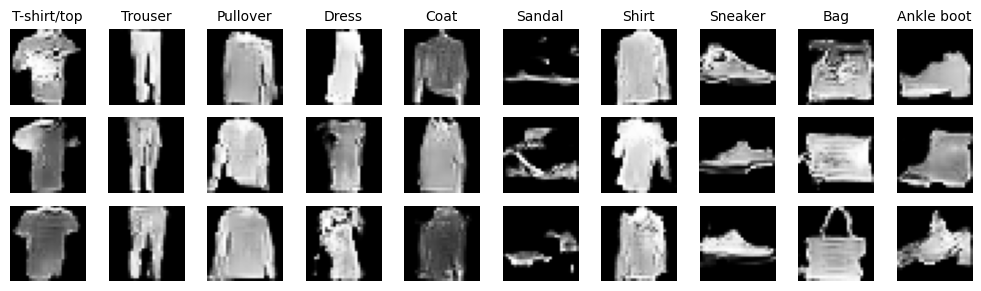

모델 저장 완료: generator_epoch_40.pth, discriminator_epoch_40.pth


Epoch [41/50] - D Loss: 0.6460, G Loss: 2.2395, D(x): 0.78, D(G(z)): 0.22


Epoch [42/50] - D Loss: 0.6524, G Loss: 2.2815, D(x): 0.78, D(G(z)): 0.22


Epoch [43/50] - D Loss: 0.6385, G Loss: 2.2786, D(x): 0.78, D(G(z)): 0.22


Epoch [44/50] - D Loss: 0.6023, G Loss: 2.3451, D(x): 0.79, D(G(z)): 0.21


Epoch [45/50] - D Loss: 0.6175, G Loss: 2.3816, D(x): 0.79, D(G(z)): 0.21


Epoch [46/50] - D Loss: 0.6259, G Loss: 2.4087, D(x): 0.79, D(G(z)): 0.21


Epoch [47/50] - D Loss: 0.6094, G Loss: 2.4079, D(x): 0.79, D(G(z)): 0.21


Epoch [48/50] - D Loss: 0.6068, G Loss: 2.4481, D(x): 0.79, D(G(z)): 0.20


Epoch [49/50] - D Loss: 0.5779, G Loss: 2.5052, D(x): 0.80, D(G(z)): 0.20


Epoch [50/50] - D Loss: 0.5888, G Loss: 2.5026, D(x): 0.80, D(G(z)): 0.20


Validation[50] - D Loss: 0.7238, G Loss: 2.2793, D(x): 0.52, D(G(z)): 0.17


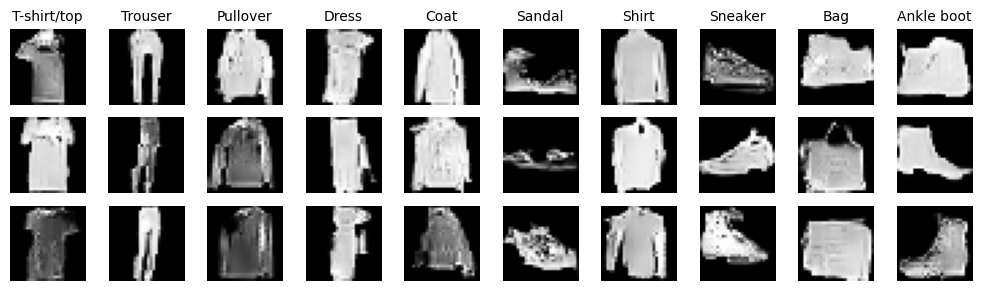

모델 저장 완료: generator_epoch_50.pth, discriminator_epoch_50.pth


In [ ]:
# 학습루프
for epoch in range(num_epochs):
    generator.train()
    discriminator.train()

    running_d_loss = 0.0
    running_g_loss = 0.0
    d_x_total = 0.0
    d_gz_total = 0.0
    total_samples = 0

    # 학습 진행 바
    train_progress = tqdm(train_loader, total=len(train_loader), leave=False)
    for i, (images, labels) in enumerate(train_progress):
        batch_size_current = images.size(0)
        total_samples += batch_size_current
        images, labels = images.to(device), labels.to(device)

        valid = torch.ones(batch_size_current, 1, device=device)
        fake = torch.zeros(batch_size_current, 1, device=device)

        # 판별자 학습
        optimizer_D.zero_grad()

        # 진짜 이미지 판별
        real_pred = discriminator(images, labels)
        real_loss = criterion(real_pred, valid)
        d_x_total += real_pred.mean().item() * batch_size_current

        # 가짜 이미지 생성
        noise = torch.randn(batch_size_current, z_dim, device=device)
        gen_labels = labels
        gen_images = generator(noise, gen_labels)

        # 가짜 이미지 판별
        fake_pred = discriminator(gen_images.detach(), labels)
        fake_loss = criterion(fake_pred, fake)
        d_gz_total += fake_pred.mean().item() * batch_size_current

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # 생성자 학습
        optimizer_G.zero_grad()
        g_loss = criterion(discriminator(gen_images, gen_labels), valid)
        g_loss.backward()
        optimizer_G.step()

        # 러닝 로스
        running_d_loss += d_loss.item() * batch_size_current
        running_g_loss += g_loss.item() * batch_size_current

        # 진행바 업데이트
        train_progress.set_description(f"Epoch [{epoch+1}/{num_epochs}] - D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    # 평균 손실, 확률 계산
    avg_d_loss = running_d_loss / total_samples
    avg_g_loss = running_g_loss / total_samples
    avg_d_x = d_x_total / total_samples
    avg_d_gz = d_gz_total / total_samples

    print(f"Epoch [{epoch+1}/{num_epochs}] - D Loss: {avg_d_loss:.4f}, G Loss: {avg_g_loss:.4f}, D(x): {avg_d_x:.2f}, D(G(z)): {avg_d_gz:.2f}")

    # 10 에포크마다 검증 데이터 평가, 생성 이미지 시각화, 모델 저장
    if (epoch + 1) % 10 == 0:
        generator.eval()
        discriminator.eval()

        val_d_loss = 0.0
        val_g_loss = 0.0
        d_x_val = 0.0
        d_gz_val = 0.0
        total_val_samples = 0

        with torch.no_grad():
            val_progress = tqdm(val_loader, total=len(val_loader), leave=False)
            for val_imgs, val_labels in val_progress:
                batch_size_val = val_imgs.size(0)
                total_val_samples += batch_size_val
                val_imgs, val_labels = val_imgs.to(device), val_labels.to(device)

                valid = torch.ones(batch_size_val, 1, device=device)
                fake = torch.zeros(batch_size_val, 1, device=device)

                # 진짜 이미지 판별
                real_pred_val = discriminator(val_imgs, val_labels)
                real_loss_val = criterion(real_pred_val, valid)
                d_x_val += real_pred_val.mean().item() * batch_size_val

                # 가짜 이미지 생성
                noise_val = torch.randn(batch_size_val, z_dim, device=device)
                gen_labels_val = val_labels
                gen_imgs_val = generator(noise_val, gen_labels_val)

                # 가짜 이미지 판별
                fake_pred_val = discriminator(gen_imgs_val, val_labels)
                fake_loss_val = criterion(fake_pred_val, fake)
                d_gz_val += fake_pred_val.mean().item() * batch_size_val

                # 생성자 손실
                g_loss_val = criterion(discriminator(gen_imgs_val, gen_labels_val), valid)
                val_g_loss += g_loss_val.item() * batch_size_val

                #
                val_d_loss += real_loss_val.item() * batch_size_val
                val_g_loss += fake_loss_val.item() * batch_size_val

        avg_val_d_loss = val_d_loss / total_val_samples
        avg_val_g_loss = val_g_loss / total_val_samples
        avg_val_d_x = d_x_val / total_val_samples
        avg_val_d_gz = d_gz_val / total_val_samples
        print(f"Validation[{epoch+1}] - D Loss: {avg_val_d_loss:.4f}, G Loss: {avg_val_g_loss:.4f}, D(x): {avg_val_d_x:.2f}, D(G(z)): {avg_val_d_gz:.2f}")

        # 시각화
        n_row = 3   # 클래스별 3개
        n_col = 10  # 총 10개 클래스
        total_samples = n_row * n_col
        noise = torch.randn(total_samples, z_dim, device=device)
        labels_sample = torch.arange(0, 10, device=device).repeat(n_row)
        gen_imgs = generator(noise, labels_sample).detach().cpu()

        # 정규화 해제
        gen_imgs = gen_imgs.clone() * 0.5 + 0.5
        gen_imgs = gen_imgs.clamp(0, 1)

        # 서브플롯 생성
        fig, axes = plt.subplots(n_row, n_col, figsize=(n_col, n_row))
        for i in range(n_row):
            for j in range(n_col):
                idx = i * n_col + j
                axes[i, j].imshow(gen_imgs[idx, 0, :, :], cmap='gray')
                axes[i, j].axis('off')
                if i == 0:
                    axes[i, j].set_title(idx_to_class[j], fontsize=10)
        plt.tight_layout()
        plt.show()

        generator.train()
        discriminator.train()

        # 모델 저장
        torch.save(generator.state_dict(), f"generator_epoch_{epoch+1}.pth")
        torch.save(discriminator.state_dict(), f"discriminator_epoch_{epoch+1}.pth")
        print(f"모델 저장 완료: generator_epoch_{epoch+1}.pth, discriminator_epoch_{epoch+1}.pth")

Test D Loss: 0.9142


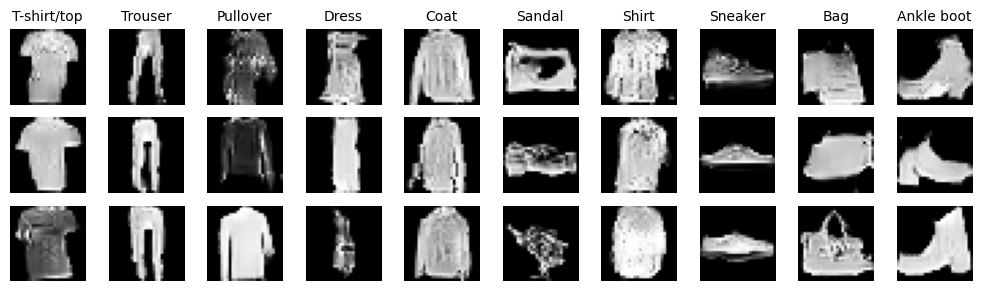

In [ ]:
# 모델 불러오기
generator.load_state_dict(torch.load("generator_epoch_50.pth", weights_only=True))
discriminator.load_state_dict(torch.load("discriminator_epoch_50.pth", weights_only=True))

# 테스트 데이터 평가
generator.eval()
discriminator.eval()

test_d_loss = 0.0
total_test_samples = 0

with torch.no_grad():
    for test_imgs, test_labels in test_loader:
        batch_size_test = test_imgs.size(0)
        total_test_samples += batch_size_test

        test_imgs, test_labels = test_imgs.to(device), test_labels.to(device)

        valid = torch.ones(batch_size_test, 1, device=device)
        fake = torch.zeros(batch_size_test, 1, device=device)

        real_pred_test = discriminator(test_imgs, test_labels)
        real_loss_test = criterion(real_pred_test, valid)

        noise_test = torch.randn(batch_size_test, z_dim, device=device)
        gen_labels_test = test_labels
        gen_imgs_test = generator(noise_test, gen_labels_test)

        fake_pred_test = discriminator(gen_imgs_test, test_labels)
        fake_loss_test = criterion(fake_pred_test, fake)

        d_loss_test = real_loss_test + fake_loss_test
        test_d_loss += d_loss_test.item() * batch_size_test

avg_test_d_loss = test_d_loss / total_test_samples

print(f"Test D Loss: {avg_test_d_loss:.4f}")

# 테스트 데이터 기반 이미지 생성 평가
n_row = 3   # 클래스별 3개
n_col = 10  # 총 10개 클래스
total_samples = n_row * n_col

# 테스트 데이터에서 라벨 추출
noise_test_sample = torch.randn(total_samples, z_dim, device=device)
test_labels_sample = torch.arange(0, num_classes, device=device).repeat(n_row)
gen_imgs_test_sample = generator(noise_test_sample, test_labels_sample).detach().cpu()

# 정규화 해제
gen_imgs_test_sample = gen_imgs_test_sample.clone() * 0.5 + 0.5
gen_imgs_test_sample = gen_imgs_test_sample.clamp(0, 1)

# 서브플롯 생성
fig, axes = plt.subplots(n_row, n_col, figsize=(n_col, n_row))
for i in range(n_row):
    for j in range(n_col):
        idx = i * n_col + j
        axes[i, j].imshow(gen_imgs_test_sample[idx, 0, :, :], cmap='gray')
        axes[i, j].axis('off')
        if i == 0:
            axes[i, j].set_title(idx_to_class[test_labels_sample[j].item()], fontsize=10)
plt.tight_layout()
plt.show()

그 외 평가지표

1. Inception score: Sharpness (S) + Diversity (D)
2. Frechet Inception Distance (FID): 평균의 차의 제곱 + 공분산(covariance)
3. Human
